In [43]:
import numpy as np

from PIL import Image
from numpy.linalg import inv


In [44]:

def img_to_array(data_path, desired_size=None, view=False):
    """
    Util function for loading RGB image into 4D numpy array.
    Returns array of shape (1, H, W, C)
    References
    ----------
    - adapted from keras preprocessing/image.py
    """
    img = Image.open(data_path)
    img = img.convert('RGB')
    if desired_size:
        img = img.resize((desired_size[1], desired_size[0]))
    if view:
        img.show()
    x = np.asarray(img, dtype='float32')
    x = np.expand_dims(x, axis=0)
    x /= 255.0
    return x


def array_to_img(x):
    """
    Util function for converting 4D numpy array to numpy array.
    Returns PIL RGB image.
    References
    ----------
    - adapted from keras preprocessing/image.py
    """
    x = np.asarray(x)
    x += max(-np.min(x), 0)
    x_max = np.max(x)
    if x_max != 0:
        x /= x_max
    x *= 255
    return Image.fromarray(x.astype('uint8'), 'RGB')

In [45]:
img1 = img_to_array('/Users/chamathabeysinghe/Desktop/img/smartest-dog-breeds-1553287693.jpg', (400, 400))
img2 = img_to_array('/Users/chamathabeysinghe/Desktop/img/The-German-Shepherd-1024x576.png', (400, 400))

input_img = np.concatenate([img1, img2], axis=0)


In [46]:
def plot_grid(image_batch, function=None):
   fig = plt.figure()

   for image_arg in range(2):
       plt.subplot(1,2, image_arg + 1)
       plt.imshow(image_batch[image_arg], cmap='gray')
       plt.axis('off')
   fig.canvas.draw()
   plt.show()


In [47]:
def batch_transform(input_img, M):
    num_batch, H, W, C = input_img.shape
    M = np.resize(M, (num_batch, 2, 3))
    
    x = np.linspace(-1, 1, W)
    y = np.linspace(-1, 1, H)
    x_t, y_t = np.meshgrid(x, y)
    
    ones = np.ones(np.prod(x_t.shape))
    sampling_grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
    
    sampling_grid = np.resize(sampling_grid, (num_batch, 3, H*W))
    
    # transform the sampling grid i.e. batch multiply
    batch_grids = np.matmul(M, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)

    # reshape to (num_batch, height, width, 2)
    batch_grids = batch_grids.reshape(num_batch, 2, H, W)
    batch_grids = np.moveaxis(batch_grids, 1, -1)
    
    x_s = batch_grids[:, :, :, 0:1].squeeze()
    y_s = batch_grids[:, :, :, 1:2].squeeze()

    # rescale x and y to [0, W/H]
    x = ((x_s + 1.) * W) * 0.5
    y = ((y_s + 1.) * H) * 0.5
    
    
    x0 = np.floor(x).astype(np.int64)
    x1 = x0 + 1
    y0 = np.floor(y).astype(np.int64)
    y1 = y0 + 1
    
    
    # make sure it's inside img range [0, H] or [0, W]
    x0 = np.clip(x0, 0, W-1)
    x1 = np.clip(x1, 0, W-1)
    y0 = np.clip(y0, 0, H-1)
    y1 = np.clip(y1, 0, H-1)
    
    
    # look up pixel values at corner coords
    Ia = input_img[np.arange(num_batch)[:,None,None], y0, x0]
    Ib = input_img[np.arange(num_batch)[:,None,None], y1, x0]
    Ic = input_img[np.arange(num_batch)[:,None,None], y0, x1]
    Id = input_img[np.arange(num_batch)[:,None,None], y1, x1]
    
    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)
    
    # add dimension for addition
    wa = np.expand_dims(wa, axis=3)
    wb = np.expand_dims(wb, axis=3)
    wc = np.expand_dims(wc, axis=3)
    wd = np.expand_dims(wd, axis=3)

    # compute output
    out = wa*Ia + wb*Ib + wc*Ic + wd*Id
    
    return out

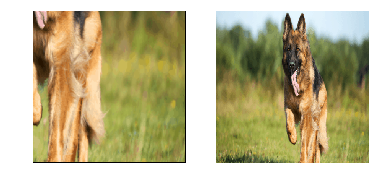

In [83]:
M = np.array([[0.5, 0., 0.5], [0, 0.5, 0.5]])
outputs_1 = batch_transform(input_img, M)
plot_grid([array_to_img(outputs_1[1]), array_to_img(input_img[1])])

In [66]:
inv_M = np.array([[ 1.,  0.,  -1.], [0., 1., -1.],])

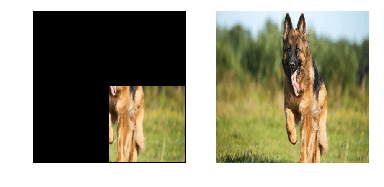

In [67]:
outputs_2 = batch_transform(outputs_1, inv_M)
plot_grid([array_to_img(outputs_2[1]), array_to_img(input_img[1])])

In [64]:
inv(np.array([[0, -1.5, 0.], [1, 0.6, 0.],[0 , 0, 1]]))

array([[ 0.4       ,  1.        ,  0.        ],
       [-0.66666667, -0.        , -0.        ],
       [ 0.        ,  0.        ,  1.        ]])